### COVID-19 Predictions

In [344]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 
import os

plt.rc('font', size=6)

In [345]:
df = pd.read_csv('data/cases_and_deaths.csv')
df = df.fillna(0)
df['date'] = pd.to_datetime(df['date']).astype('int64')
df.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
0,1578009600000000000,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1578096000000000000,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1578182400000000000,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1578268800000000000,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1578355200000000000,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's take only Indonesia's data

In [346]:
df = df.loc[df['location'] == 'Indonesia']
df.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
114600,1578009600000000000,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114601,1578096000000000000,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114602,1578182400000000000,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114603,1578268800000000000,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114604,1578355200000000000,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


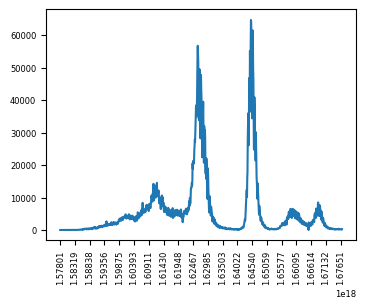

In [347]:
fig = plt.figure(figsize=(4, 3))
plt.xticks(df['date'][::60], rotation=90)
plt.plot(df['date'], df['new_cases'])

In [348]:
clean_df = df[['date', 'new_cases']]
clean_df.head()

,date,new_cases
114600,1578009600000000000,0.0
114601,1578096000000000000,0.0
114602,1578182400000000000,0.0
114603,1578268800000000000,0.0
114604,1578355200000000000,0.0


In [349]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse

In [350]:
additive_decomposition = seasonal_decompose(clean_df['new_cases'], model='additive', period=30)

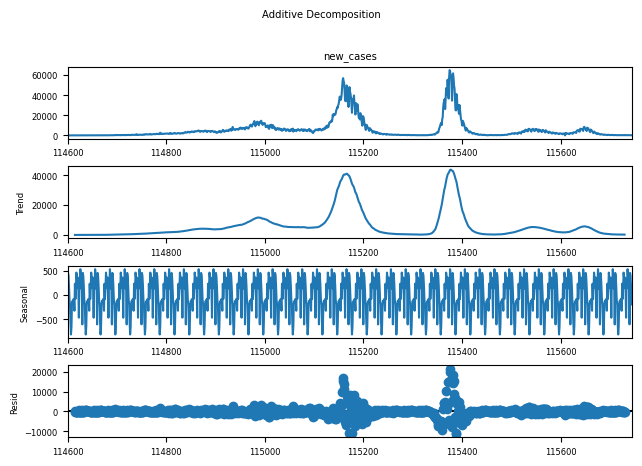

In [351]:
additive_decomposition.plot().suptitle('Additive Decomposition')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [352]:
# Test for Stationarity

result = adfuller(clean_df['new_cases'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -4.234573284528693
n_lags: 0.000575520897795083
p-value: 0.000575520897795083
Critial Values:
   1%, -3.4361916433888267
Critial Values:
   5%, -2.864119416599365
Critial Values:
   10%, -2.568143354336063


p-value is less than $0.05$ so the data is more or less stationary

In [353]:
detrended = clean_df['new_cases'].values - additive_decomposition.trend

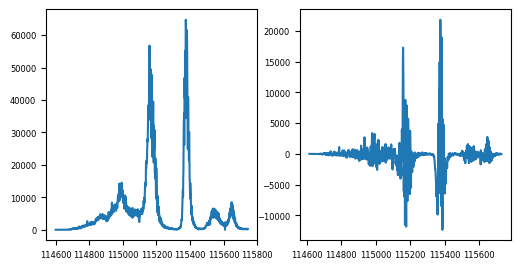

In [354]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.plot(clean_df['new_cases'])
ax2.plot(detrended)

In [355]:
deseasonalized = clean_df['new_cases'].values / additive_decomposition.seasonal

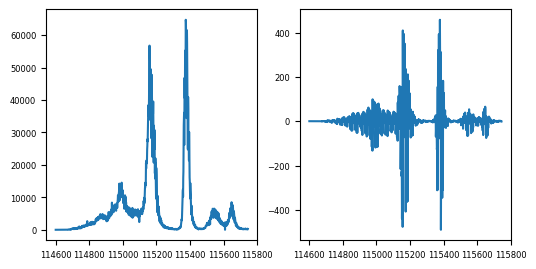

In [356]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.plot(clean_df['new_cases'])
ax2.plot(deseasonalized)

j:\covid19\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


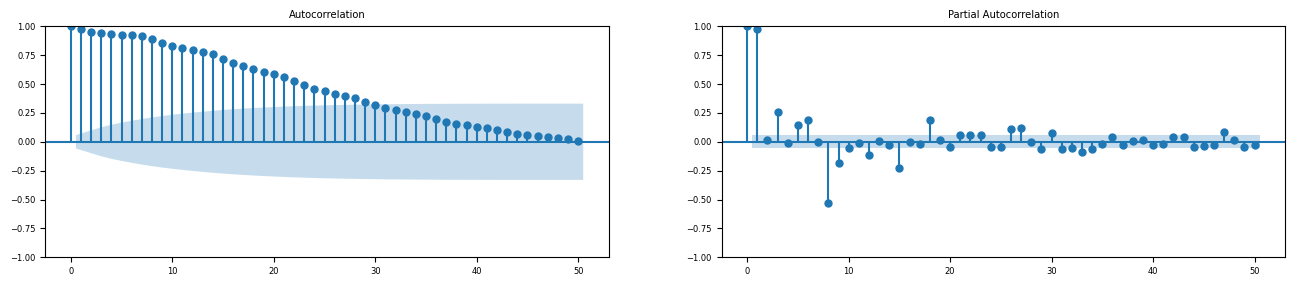

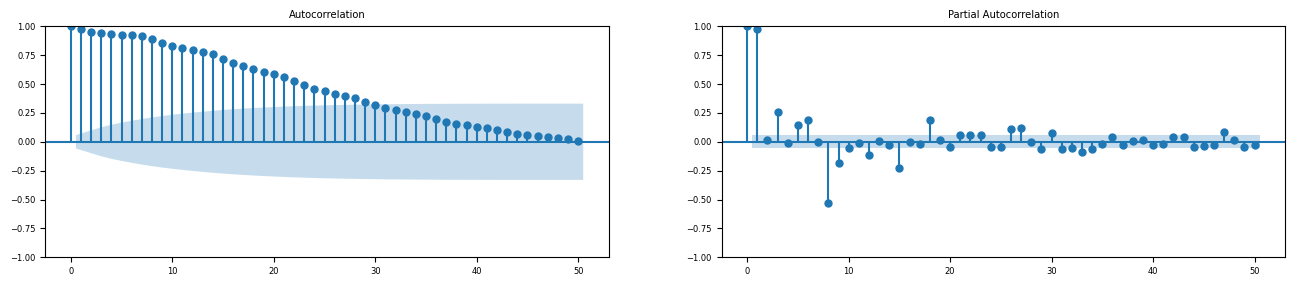

In [357]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(clean_df['new_cases'].tolist(), lags=50, ax=axes[0])
plot_pacf(clean_df['new_cases'].tolist(), lags=50, ax=axes[1])

Creating the Model

In [358]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [359]:
data_raw = clean_df['new_cases'].values.astype('float32').reshape(-1, 1)

In [360]:
data_raw.shape

(1146, 1)

In [361]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [362]:
dataset = scaler.fit_transform(data_raw)

In [363]:
dataset.shape

(1146, 1)

In [364]:
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (916, 230)


In [365]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [366]:
# Create test and training sets for one-step-ahead regression.
window_size = 50
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)


# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(865, 50)
New training data shape:
(865, 1, 50)


In [368]:
model = Sequential()

In [369]:
model.add(LSTM(input_shape=(1, window_size),
               units=window_size,
               return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="mse", optimizer="adam")
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_23 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_28 (LSTM)              (None, 256)               314368    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
 activation_10 (Activation)  (None, 1)                 0         
                                                                 
Total params: 334,825
Trainable params: 334,825
Non-t

In [370]:
model.fit(train_X, train_Y, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
28/28 - 4s - loss: 0.1599 - 4s/epoch - 130ms/step
Epoch 2/1000
28/28 - 0s - loss: 0.0934 - 225ms/epoch - 8ms/step
Epoch 3/1000
28/28 - 0s - loss: 0.0372 - 238ms/epoch - 8ms/step
Epoch 4/1000
28/28 - 0s - loss: 0.0146 - 217ms/epoch - 8ms/step
Epoch 5/1000
28/28 - 0s - loss: 0.0098 - 214ms/epoch - 8ms/step
Epoch 6/1000
28/28 - 0s - loss: 0.0066 - 226ms/epoch - 8ms/step
Epoch 7/1000
28/28 - 0s - loss: 0.0054 - 224ms/epoch - 8ms/step
Epoch 8/1000
28/28 - 0s - loss: 0.0041 - 241ms/epoch - 9ms/step
Epoch 9/1000
28/28 - 0s - loss: 0.0040 - 236ms/epoch - 8ms/step
Epoch 10/1000
28/28 - 0s - loss: 0.0034 - 239ms/epoch - 9ms/step
Epoch 11/1000
28/28 - 0s - loss: 0.0031 - 217ms/epoch - 8ms/step
Epoch 12/1000
28/28 - 0s - loss: 0.0029 - 230ms/epoch - 8ms/step
Epoch 13/1000
28/28 - 0s - loss: 0.0028 - 219ms/epoch - 8ms/step
Epoch 14/1000
28/28 - 0s - loss: 0.0032 - 223ms/epoch - 8ms/step
Epoch 15/1000
28/28 - 0s - loss: 0.0027 - 223ms/epoch - 8ms/step
Epoch 16/1000
28/28 - 0s - loss: 0.

In [371]:
def predict_and_score(model, X, Y):
    pred_scaled = model.predict(X)
    pred = scaler.inverse_transform(pred_scaled)
    orig_data = scaler.inverse_transform([Y])
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, pred_scaled)

rmse_train, train_predict, train_predict_scaled = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict, test_predict_scaled = predict_and_score(model, test_X, test_Y)

print(f"Training RMSE: {rmse_train} RMSE")
print(f"Test RMSE: {rmse_test} RMSE")

test_predict.size

28/28 [==============================] - 1s 3ms/step
[[[0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]]

 ...

 [[0.00475911 0.00397107 0.0028122  ... 0.03473531 0.03166043 0.02772026]]

 [[0.00397107 0.0028122  0.00381656 ... 0.03166043 0.02772026 0.02493897]]

 [[0.0028122  0.00381656 0.00505269 ... 0.02772026 0.02493897 0.02215767]]]
6/6 [==============================] - 0s 3ms/step
[[[0.04451621 0.03819648 0.04179672 ... 0.07506412 0.08387156 0.08056491]]

 [[0.03819648 0.04179672 0.03980345 ... 0.08387156 0.08056491 0.07028956]]

 [[0.04179672 0.03980345 0.02597423 ... 0.08056491 0.07028956 0.06443339]]

 ...

 [[0.00852931 0.00754041 0.0056553  ... 0.00406378 0.00338391 0.0033221 ]]

 [[0.00754041 0.0056553  0.00404833 ... 0.00338391 0.0033221  0.00293581]]

 [[0.0056553  0.00404833 0.01007448 ... 0.003322

179

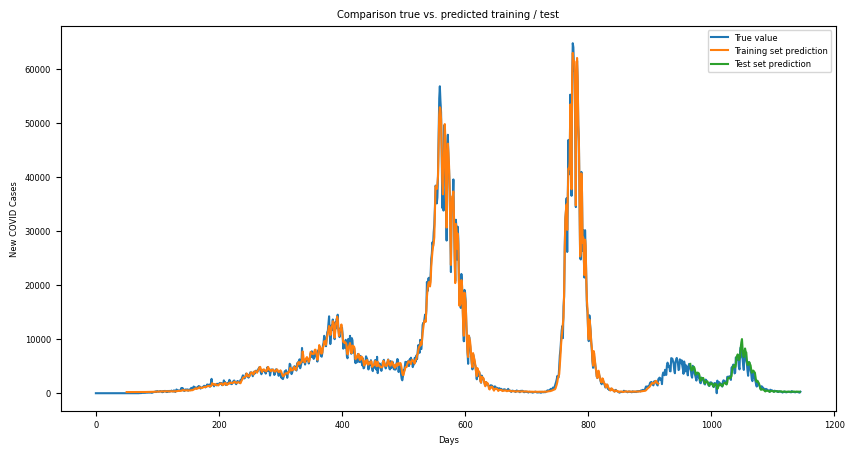

In [372]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict
plt.figure(figsize = (10, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("New COVID Cases")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

In [538]:
# Create Predictions

def predict(T, X):
    X_val=X.reshape(1, 1, 50)

    predictions = []

    for t in range(T):
        P = model.predict(X_val[-1].reshape(1, 1, window_size))
        predictions.append(P[0][0])
        new_X_val = X_val[-1][0].reshape(window_size)
        new_X_val = new_X_val[1:]
        P = P[0].reshape(1)
        new_X_val = np.concatenate((new_X_val, P), axis=0)
        X_val = np.concatenate((X_val, [[new_X_val]]))

    predictions = [predictions]
    predictions_scaled = scaler.inverse_transform(predictions)

    return predictions, predictions_scaled

    

In [539]:
predictions, predictions_scaled = predict(10, test_X[-1])

1/1 [==============================] - 0s 50ms/step
(49,)
(1,)
New X Val = [0.00404833 0.01007448 0.00922464 0.00826663 0.00801941 0.0070305
 0.00533082 0.00411014 0.00724682 0.00621156 0.00636608 0.00560895
 0.00601069 0.00369294 0.00347662 0.00551624 0.00523811 0.00479001
 0.00451188 0.00367749 0.00336846 0.00183875 0.00336846 0.00423375
 0.00497543 0.0032603  0.00307488 0.00254952 0.00282765 0.00401743
 0.0042183  0.00383201 0.00372385 0.00287401 0.00264223 0.00261133
 0.00605705 0.00406378 0.00339936 0.00369294 0.00309033 0.00279675
 0.00261133 0.00381656 0.00406378 0.00338391 0.0033221  0.00293581
 0.00174604 0.0040857 ]
1/1 [==============================] - 0s 41ms/step
(49,)
(1,)
New X Val = [0.01007448 0.00922464 0.00826663 0.00801941 0.0070305  0.00533082
 0.00411014 0.00724682 0.00621156 0.00636608 0.00560895 0.00601069
 0.00369294 0.00347662 0.00551624 0.00523811 0.00479001 0.00451188
 0.00367749 0.00336846 0.00183875 0.00336846 0.00423375 0.00497543
 0.0032603  0.00307488 

In [541]:
print(predictions_scaled)

[[264.41846742 280.77900181 288.26823519 296.64306471 305.77528899
  304.80901699 302.10244278 305.0808196  315.33976351 319.68694782]]
